IMPORTAMOS LAS LIBRERÍAS

In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
import cv2
import json 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

from sklearn.metrics import classification_report


# Configuración para visualización de imágenes
%matplotlib inline

2024-07-02 12:57:20.536075: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


CARGAMOS EL ARCHIVO

In [2]:
photos = pd.read_json("photos.json", lines = True)

In [3]:
photos.head()

photo_id             business_id  \
0  zsvj7vloL4L5jhYyPIuVwg  Nk-SJhPlDBkAZvfsADtccA   
1  HCUdRJHHm_e0OCTlZetGLg  yVZtL5MmrpiivyCIrVkGgA   
2  vkr8T0scuJmGVvN2HJelEA  _ab50qdWOk0DdB6XOrBitw   
3  pve7D6NUrafHW3EAORubyw  SZU9c8V2GuREDN5KgyHFJw   
4  H52Er-uBg6rNrHcReWTD2w  Gzur0f0XMkrVxIwYJvOt2g   

                                             caption    label  
0  Nice rock artwork everywhere and craploads of ...   inside  
1                                                     outside  
2                                     oyster shooter    drink  
3                                      Shrimp scampi     food  
4                                                        food

In [4]:
photos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200100 entries, 0 to 200099
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   photo_id     200100 non-null  object
 1   business_id  200100 non-null  object
 2   caption      200100 non-null  object
 3   label        200100 non-null  object
dtypes: object(4)
memory usage: 6.1+ MB


TRAS LAS PRIMERAS CONCLUSIONES, HORA DE PROCEDER CON LA LIMPIEZA DEL DF

In [5]:
photos1 = photos.drop(columns=['caption']) #eliminamos la columna caption

In [6]:
photos1.head() #chequeamos la eliminación

photo_id             business_id    label
0  zsvj7vloL4L5jhYyPIuVwg  Nk-SJhPlDBkAZvfsADtccA   inside
1  HCUdRJHHm_e0OCTlZetGLg  yVZtL5MmrpiivyCIrVkGgA  outside
2  vkr8T0scuJmGVvN2HJelEA  _ab50qdWOk0DdB6XOrBitw    drink
3  pve7D6NUrafHW3EAORubyw  SZU9c8V2GuREDN5KgyHFJw     food
4  H52Er-uBg6rNrHcReWTD2w  Gzur0f0XMkrVxIwYJvOt2g     food

In [7]:
def df_1(photo_id): #aplicamos un filtro para las imágenes corruptas del df
    try:
        Image.open(f"photos1/{photo_id}.jpg")
        return True
    except:
        return False

lista_images = photos1["photo_id"].to_list()
corrupt_images = []
for imagen in lista_images:
     if not df_1(imagen):
         corrupt_images.append(imagen)    


In [8]:
photos2 = photos1.drop(columns=['business_id']) #photos2: sin la colunma de business id

In [9]:
photos2.head() #chequeamos 

photo_id    label
0  zsvj7vloL4L5jhYyPIuVwg   inside
1  HCUdRJHHm_e0OCTlZetGLg  outside
2  vkr8T0scuJmGVvN2HJelEA    drink
3  pve7D6NUrafHW3EAORubyw     food
4  H52Er-uBg6rNrHcReWTD2w     food

In [10]:
photos2.info() #vemos cómo ha quedado todo tras la eliminación de las dos columnas

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200100 entries, 0 to 200099
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   photo_id  200100 non-null  object
 1   label     200100 non-null  object
dtypes: object(2)
memory usage: 3.1+ MB


Tenemos más de 200.000 datos. Es hora de ver la proporción en las labels y determinar si procede suprimir datos de alguna de alguna de ellas (de forma aleatoria porque el df ya está limpio gracias al filtro aplicado). El fin es que el df no esté desproporcionado en sus distintas categorías de imágenes 

In [11]:
conteo_categorias = photos2['label'].value_counts() #contamos

print(conteo_categorias)

label
food       108152
inside      56031
outside     18569
drink       15670
menu         1678
Name: count, dtype: int64


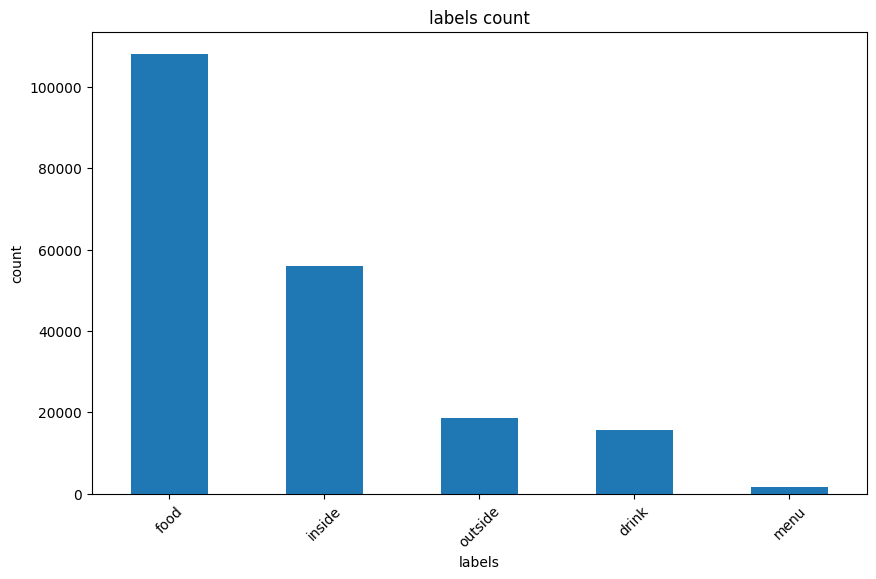

In [12]:
plt.figure(figsize=(10, 6))
conteo_categorias.plot(kind='bar')
plt.title('labels count')
plt.xlabel('labels')
plt.ylabel('count')
plt.xticks(rotation=45)
plt.show()

HAY MUCHA DESPROPORCIÓN EN LOS DATOS. TOCA AJUSTARLOS

In [13]:
print(conteo_categorias)

label
food       108152
inside      56031
outside     18569
drink       15670
menu         1678
Name: count, dtype: int64


In [14]:
def igualar1(photos2, etiqueta_columna, valor_columna, etiqueta_valor, num_filas):
    # Filtrar las filas que tienen la etiqueta específica
    filas_etiqueta = photos2[photos2[etiqueta_columna] == etiqueta_valor]
    
    # Verifica que num_filas no sea mayor que el total de filas con la etiqueta específica
    if num_filas > len(filas_etiqueta):
        raise ValueError("Error, coge un número más chico")
    
    # Seleccionar aleatoriamente los índices de las filas a eliminar
    indices_a_eliminar = np.random.choice(filas_etiqueta.index, num_filas, replace=False)
    
    # Eliminar las filas seleccionadas del dataset original
    photos3 = photos2.drop(indices_a_eliminar)
    
    return photos3 #photos3 se aplicará al df con la reducción de la etiqueta "food"

# Parámetros
etiqueta_columna = 'label'  # Nombre de la columna con la etiqueta
valor_columna = 'photo_id'       # Nombre de la columna con el valor asociado
etiqueta_valor = 'food'            # Valor específico de la etiqueta
num_filas = 106000                   # Número de filas a eliminar

# Eliminar filas con la etiqueta específica y su valor asociado
photos3 = igualar1(photos2, etiqueta_columna, valor_columna, etiqueta_valor, num_filas)





In [15]:
conteo_categorias2 = photos3['label'].value_counts() #una vez reducido food

print(conteo_categorias2)

label
inside     56031
outside    18569
drink      15670
food        2152
menu        1678
Name: count, dtype: int64


In [15]:
#A SEGUIR QUITANDO
def igualar2(photos3, etiqueta_columna, valor_columna, etiqueta_valor, num_filas):
    
    filas_etiqueta = photos3[photos3[etiqueta_columna] == etiqueta_valor]
    
    
    if num_filas > len(filas_etiqueta):
        raise ValueError("Error, coge un número más chico")
    
    
    indices_a_eliminar = np.random.choice(filas_etiqueta.index, num_filas, replace=False)
    
    
    photos4 = photos3.drop(indices_a_eliminar)
    
    return photos4 #photos4 se aplicará al df con la reducción de la etiqueta "inside"

# Parámetros
etiqueta_columna = 'label'  # Nombre de la columna con la etiqueta
valor_columna = 'photo_id'       # Nombre de la columna con el valor asociado
etiqueta_valor = 'inside'            # Valor específico de la etiqueta
num_filas = 53802                  # Número de filas a eliminar


photos4 = igualar2(photos3, etiqueta_columna, valor_columna, etiqueta_valor, num_filas)

In [16]:
conteo_categorias3 = photos4['label'].value_counts() #una vez reducido food

print(conteo_categorias3)

label
outside    18569
drink      15670
inside      2229
food        2152
menu        1678
Name: count, dtype: int64


In [17]:
#A SEGUIR QUITANDO, VAMOS CON OUTSIDE
def igualar3(photos4, etiqueta_columna, valor_columna, etiqueta_valor, num_filas):
    
    filas_etiqueta = photos4[photos4[etiqueta_columna] == etiqueta_valor]
    
    
    if num_filas > len(filas_etiqueta):
        raise ValueError("Error, coge un número más chico")
    
    
    indices_a_eliminar = np.random.choice(filas_etiqueta.index, num_filas, replace=False)
    
    
    photos5 = photos4.drop(indices_a_eliminar)
    
    return photos5 #photos5 se aplicará al df con la reducción de la etiqueta "outside"

# Parámetros
etiqueta_columna = 'label'  # Nombre de la columna con la etiqueta
valor_columna = 'photo_id'       # Nombre de la columna con el valor asociado
etiqueta_valor = 'outside'            # Valor específico de la etiqueta
num_filas = 16101                  # Número de filas a eliminar


photos5 = igualar3(photos4, etiqueta_columna, valor_columna, etiqueta_valor, num_filas)

In [18]:
conteo_categorias4 = photos5['label'].value_counts() #una vez reducido food

print(conteo_categorias4)

label
drink      15670
outside     2468
inside      2229
food        2152
menu        1678
Name: count, dtype: int64


In [19]:
#Ultimo DRINK
def igualar4(photos5, etiqueta_columna, valor_columna, etiqueta_valor, num_filas):
    
    filas_etiqueta = photos5[photos5[etiqueta_columna] == etiqueta_valor]
    
    
    if num_filas > len(filas_etiqueta):
        raise ValueError("Error, coge un número más chico")
    
    
    indices_a_eliminar = np.random.choice(filas_etiqueta.index, num_filas, replace=False)
    
    
    photos6 = photos5.drop(indices_a_eliminar)
    
    return photos6 #photos6 se aplicará al df con la reducción de la etiqueta "drink"

# Parámetros
etiqueta_columna = 'label'  # Nombre de la columna con la etiqueta
valor_columna = 'photo_id'       # Nombre de la columna con el valor asociado
etiqueta_valor = 'drink'            # Valor específico de la etiqueta
num_filas = 13020                 # Número de filas a eliminar


photos6 = igualar4(photos5, etiqueta_columna, valor_columna, etiqueta_valor, num_filas)

In [20]:
conteo_categorias5 = photos6['label'].value_counts() #una vez reducido food

print(conteo_categorias5)

label
drink      2650
outside    2468
inside     2229
food       2152
menu       1678
Name: count, dtype: int64


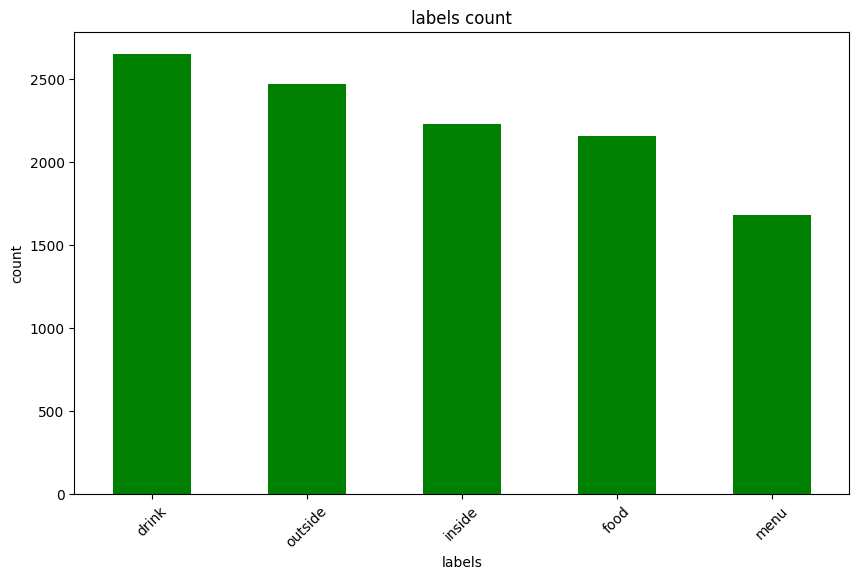

In [21]:
plt.figure(figsize=(10, 6))
conteo_categorias5.plot(kind='bar', color= 'green')
plt.title('labels count')
plt.xlabel('labels')
plt.ylabel('count')
plt.xticks(rotation=45)
plt.show()

AHORA LAS LABELS ESTÁN MÁS EQUILIBRADAS EN LA CANTIDAD DE DATOS QUE POSEEN

In [22]:
df_photos = photos6.copy() #hago una copia y lo renombro, por si las moscas

In [23]:
df_photos.tail()

photo_id    label
200069  -_hrbKI6oeem1EMDs_KK0g    drink
200071  dq0DKYNDUm1QDA8dbdgZ8A  outside
200073  ZtuEsa-qc7gfy7m5UnfaZw     menu
200076  J5chUskqCG_3d4pc3MG06Q  outside
200087  1WNyCu2drGWbYsYdGsMm2Q  outside

In [24]:
def df_2(photo_id): #aplico el filtro otra vez porque quiero y puedo
    try:
        Image.open(f"df_photos/{photo_id}.jpg")
        return True
    except:
        return False

lista_images2 = df_photos["photo_id"].to_list()
corrupt_images2 = []
for imagen2 in lista_images2:
     if not df_2(imagen2):
         corrupt_images2.append(imagen)    

In [25]:
df_photos.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11177 entries, 14 to 200087
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   photo_id  11177 non-null  object
 1   label     11177 non-null  object
dtypes: object(2)
memory usage: 262.0+ KB


In [26]:
df_photos.head(10) 

photo_id    label
14   RBBVVDG3t4lTTyl_vW2W3A   inside
16   6LJa8QZOGBjt9maE5miLhw     menu
69   DtsfhqhqUB-tjs5XbwJfXw     menu
72   9Wkj-Vl5EYLS6OIy4EYigw     food
94   pRnGI7xv7ZBJ8p_w0xy9fg    drink
99   SZ3NDrbN8IyamXlSQkV35g     food
132  rfrFsu-NvTiuB72EAO1NUQ   inside
133  IM1CWH6_ieAQMEclhWxCZQ  outside
162  2yRnSdinaARnq5_GbBz2uQ   inside
177  QHkcpEUO72VYMJ8P5449GA  outside

In [27]:
# Resetear el índice para que sea consecutivo porque vemos que las numeraciones de las filas están salteadas
df_photos.reset_index(drop=True, inplace=True)

# Mostrar el DataFrame con el índice reseteado
print("\nDataFrame con índice reseteado:")
print(df_photos.head(10))


DataFrame con índice reseteado:
                 photo_id    label
0  RBBVVDG3t4lTTyl_vW2W3A   inside
1  6LJa8QZOGBjt9maE5miLhw     menu
2  DtsfhqhqUB-tjs5XbwJfXw     menu
3  9Wkj-Vl5EYLS6OIy4EYigw     food
4  pRnGI7xv7ZBJ8p_w0xy9fg    drink
5  SZ3NDrbN8IyamXlSQkV35g     food
6  rfrFsu-NvTiuB72EAO1NUQ   inside
7  IM1CWH6_ieAQMEclhWxCZQ  outside
8  2yRnSdinaARnq5_GbBz2uQ   inside
9  QHkcpEUO72VYMJ8P5449GA  outside


In [28]:
df_photos.tail(10) 

photo_id    label
11167  wGvNUVjM5QoLQcnxVhJWKQ    drink
11168  IAS8JJCU6As27BoHpVSvEA  outside
11169  CysmQhYJ50TIIV4yh9Dy-w  outside
11170  3_PIc-mp4Mca_lV_8nHK_w   inside
11171  wq2E-d6NuiCP5_DCC_6e6g     menu
11172  -_hrbKI6oeem1EMDs_KK0g    drink
11173  dq0DKYNDUm1QDA8dbdgZ8A  outside
11174  ZtuEsa-qc7gfy7m5UnfaZw     menu
11175  J5chUskqCG_3d4pc3MG06Q  outside
11176  1WNyCu2drGWbYsYdGsMm2Q  outside

TRAS VER QUE TODO ESTÁ CORRECTO, HORA DE ABRIR LAS FOTOS Y VER QUE TODO ESTÁ OK EN LA APERTURA :) 

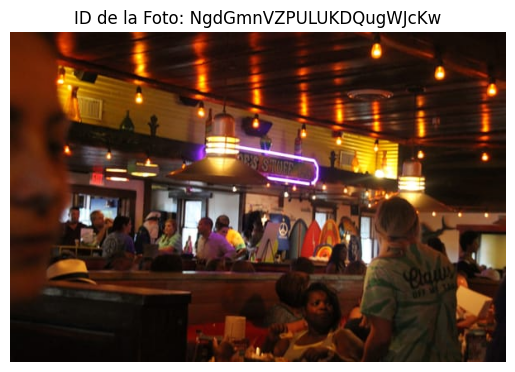

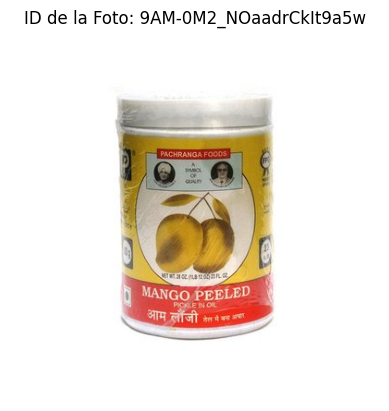

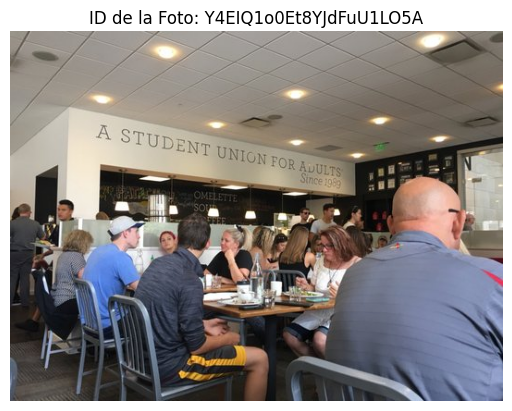

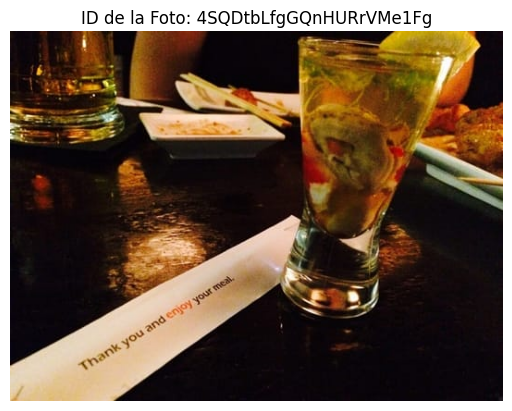

In [29]:
# Carpeta donde se encuentran las imágenes (pon la ubicación de tu carpeta)
image_folder = '/Users/florentinoromerourquiza/Documents/yelp_photos-002/photos'

photo_ids = df_photos['photo_id']

# el número de fotos que quieres que aparezcan al ejecutar esta celda (apareceran de forma aleatoria)
num_photos = 4

# Variable para seleccionar aleatoriamente las IDs de las fotos
random_photo_ids = random.sample(list(photo_ids), num_photos)

for photo_id in random_photo_ids:
    
    image_path = os.path.join(image_folder, f'{photo_id}.jpg')
    
    img = Image.open(image_path)
    
    plt.imshow(img)
    plt.title(f'ID de la Foto: {photo_id}')
    plt.axis('off')
    plt.show()

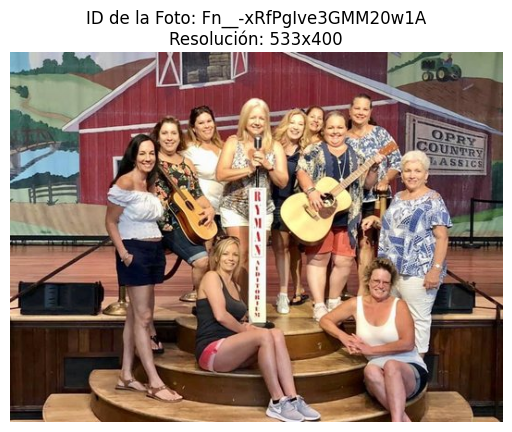

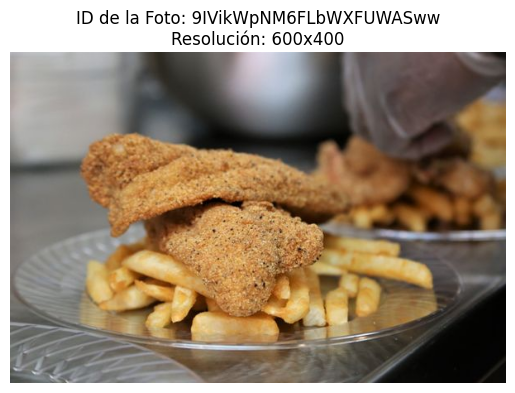

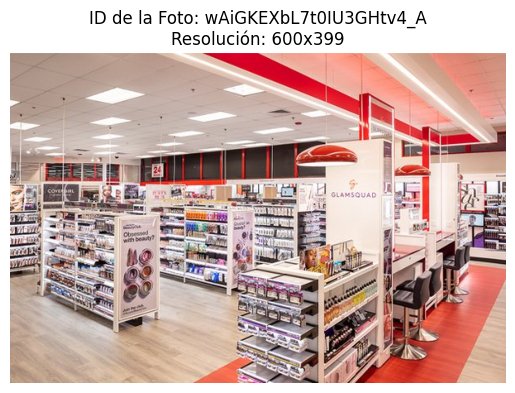

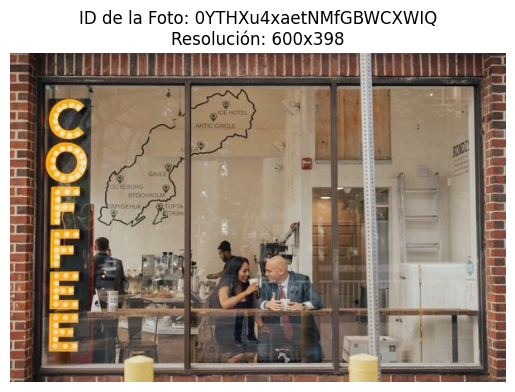

In [30]:
# Variable para seleccionar aleatoriamente las IDs de las fotos
random_photo_ids = random.sample(list(photo_ids), num_photos)

for photo_id in random_photo_ids:
    image_path = os.path.join(image_folder, f'{photo_id}.jpg')
    
    try:
        img = Image.open(image_path)
        width, height = img.size
        
        plt.imshow(img)
        plt.title(f'ID de la Foto: {photo_id}\nResolución: {width}x{height}')
        plt.axis('off')
        plt.show()
        
    except (IOError, SyntaxError) as e:
        print(f"El archivo {image_path} no es una imagen válida o está corrupto: {e}")


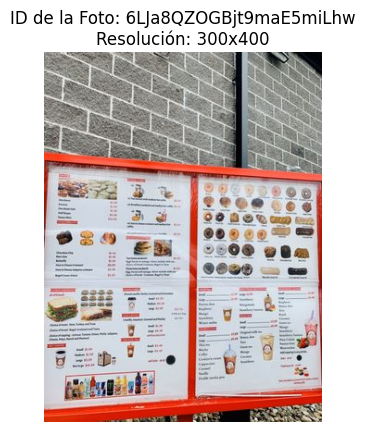

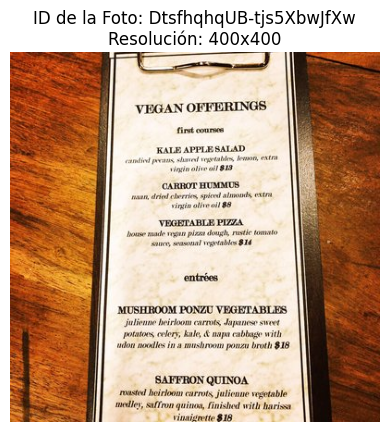

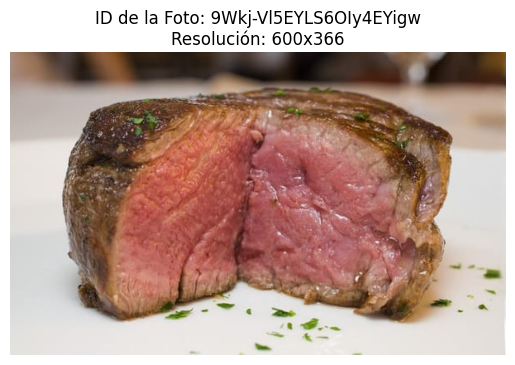

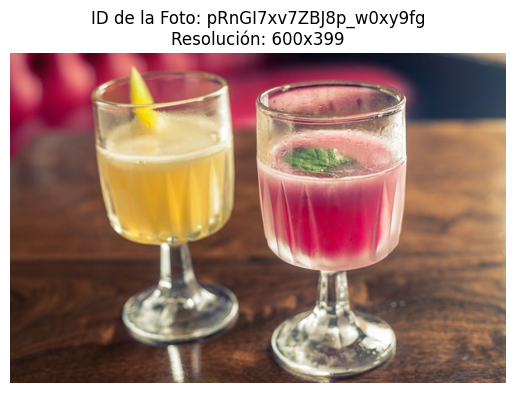

In [31]:
def mostrar_fotos(df, image_folder, start_index, end_index):
    # Obtener las IDs de las fotos dentro del rango especificado
    photo_ids = df['photo_id'][start_index:end_index+1]
    
    for photo_id in photo_ids:
        image_path = os.path.join(image_folder, f'{photo_id}.jpg')
        
        try:
            img = Image.open(image_path)
            width, height = img.size
            
            plt.imshow(img)
            plt.title(f'ID de la Foto: {photo_id}\nResolución: {width}x{height}')
            plt.axis('off')
            plt.show()
            
        except (IOError, SyntaxError) as e:
            print(f"El archivo {image_path} no es una imagen válida o está corrupto: {e}")

# Carpeta donde se encuentran las imágenes (pon la ubicación de tu carpeta)
image_folder = '/Users/florentinoromerourquiza/Documents/yelp_photos-002/photos'

# Ejemplo de uso: seleccionar fotos desde el índice 4 hasta el 10 o hasta donde digas
mostrar_fotos(df_photos, image_folder, 1, 4)

ENTRENAMIENTO ML mobile net

PASO 1: Preparación de Datos

Paso 2: Construcción del Modelo

Paso 3: Entrenamiento del Modelo

PREDICCIÓN

EVALUACIÓN